# Duck prediction
In this model we will try to recognize if a picture has a duck in it or not.

## Declare dependencies
First of all we will declare dependencies for the model to work with.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns






Now we will create a function to load the images and resize them to 400px x 300px

In [ ]:
def load_and_resize_images(folder, size=(400, 300)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(cv2.resize(img, size) ) 
    return np.array(images)


Load the data, we have a train, a val and a test folders with photos of ducks and other things

In [ ]:
train_duck_data = load_and_resize_images('Images\\Duck\\train\\images')
val_duck_data = load_and_resize_images('Images\\Duck\\val\\images')
test_duck_data = load_and_resize_images('Images\\Duck\\val\\images')

train_not_duck_data = load_and_resize_images('Images\\Not Duck\\train\\images')
val_not_duck_data = load_and_resize_images('Images\\Not Duck\\val\\images')
test_not_duck_data = load_and_resize_images('Images\\Not Duck\\val\\images')

We will create the labels for the data, we will use 1 for ducks and 0 for when the picture is not of a duck


In [3]:
duck_train_labels = np.ones(train_duck_data.shape[0])
duck_val_labels= np.ones(val_duck_data.shape[0])
duck_test_labels = np.ones(test_duck_data.shape[0])

not_duck_train_labels = np.zeros(train_not_duck_data.shape[0])
not_duck_val_labels= np.zeros(val_not_duck_data.shape[0])
not_duck_test_labels = np.zeros(test_not_duck_data.shape[0])



Now we will concatenate our data in order and then shuffle it to make it random

In [18]:
train_data = np.concatenate((train_duck_data, train_not_duck_data))
test_data = np.concatenate((test_duck_data, test_not_duck_data))
val_data = np.concatenate((val_duck_data, val_not_duck_data))

train_labels = np.concatenate((duck_train_labels, not_duck_train_labels))
test_labels = np.concatenate((duck_test_labels, not_duck_test_labels))
val_labels = np.concatenate((duck_val_labels, not_duck_val_labels))



# Shuffle the training data and labels
train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)
val_data, val_labels = shuffle(val_data, val_labels)




## Model
All set up! Now let's create a model... I used up to 128 neurons cause my GPU doesn't support more than this. Feel free of changing it to your preference.
We will have a softmax activation function to check the probability of the image being a duck or not.
If the first neuron have a better probability than the second one, the picture shouldn't be of a duck, else should be a duck.


In [6]:


# Define the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train_data.shape[1:]))  # Reduced filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))  # Reduced filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))  # Reduced filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten the output
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)

# Reduce the batch size to avoid ResourceExhaustedError
history = model.fit(train_data, train_labels, batch_size=1, epochs=20, validation_data=(val_data, val_labels), callbacks=[checkpoint])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 398, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 298, 398, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 199, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 149, 199, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 197, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 147, 197, 64)    

Now we will load the best weights that the model get (We used a checkpoint to get which epoch was)

In [7]:
# Load the best model
model.load_weights('best_model.h5')

Let's test the accuracy on the test data

In [9]:
# Evaluate the model with the test data and labels
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

127/127 [==============================] - 1s 6ms/step - loss: 34.1317 - accuracy: 0.7087
Test Accuracy: 70.87%


Ok, 70%, feels good, let's predict the test_data, we will use the class_labels to get the most likely neuron.
If np.argmax of the prediction is 0 then shouldn't be a duck, if is 1 then should be a duck

In [19]:
# Predict all test data with the model using a batch size of 1
predictions = model.predict(test_data, batch_size=1)
class_labels = np.argmax(predictions, axis=1)

accuracy = np.mean((class_labels).astype(int) == test_labels)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')

127/127 [==============================] - 1s 5ms/step
Prediction Accuracy: 70.87%


Let's plot a confusion matrix with seaborn between the test_labels and the class_labels

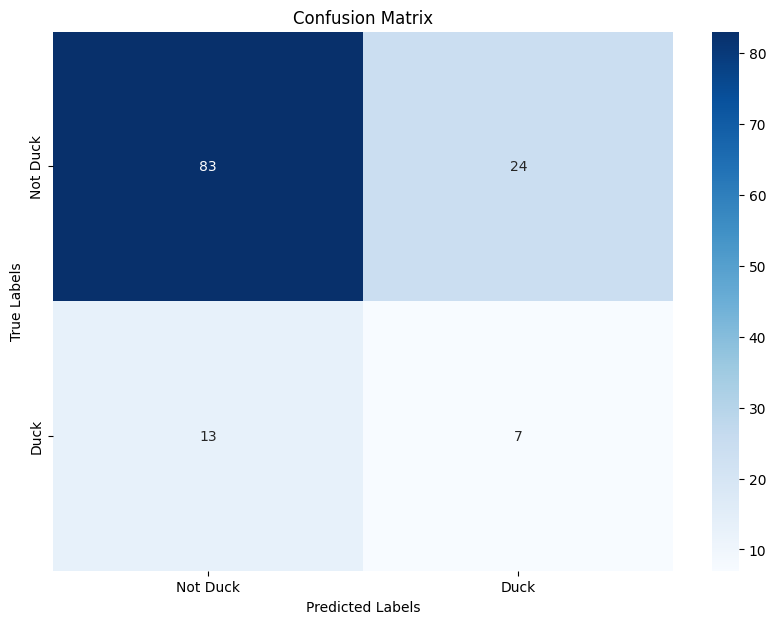

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duck', 'Duck'], yticklabels=['Not Duck', 'Duck'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Ok, in our confusion matrix we can see that there are 24 images that are not of ducks and are detected as ducks and there are 13 images that are ducks and are not detected as ducks 

Let's see this with numbers

In [25]:
predicted_ducks = 0
failed_predicted_ducks = 0
predicted_not_ducks = 0
failed_predicted_not_ducks = 0

for i in range(0,test_labels.shape[0]):
    if (test_labels[i] == 1 and class_labels[i]==1):
        predicted_ducks+=1
    elif (test_labels[i] == 1 and class_labels[i]==0):
        failed_predicted_ducks+=1
    elif (test_labels[i] == 0 and class_labels[i]==0):
        predicted_not_ducks+=1
    else:
        failed_predicted_not_ducks+=1

print("Predicted duck correctly: " + str(predicted_ducks))
print("Predicted duck incorrectly: " + str(failed_predicted_ducks))
print("Predicted not duck correctly: " + str(predicted_not_ducks))
print("Predicted not duck incorrectly: " + str(failed_predicted_not_ducks))

Predicted duck correctly: 7
Predicted duck incorrectly: 13
Predicted not duck correctly: 83
Predicted not duck incorrectly: 24
